In [27]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
from scipy.stats import describe
from scipy.signal import savgol_filter
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
import autosklearn.classification
from collections import Counter
import phase_model as pm
from phase_features_loader import PhaseFeaturesLoader
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

In [3]:
FEATURES = "data/phase/ml_features.csv"
FEATURESTINY = "data/phase/ml_features_tiny.csv"
dataset_train = "data/phase/ml_features_tiny.csv"
dataset_test = "data/phase/ml_features_test.csv"
dataset_train_out = "data/phase/ml_features_tiny_out.csv"
STA = "URZ"
phases = ["regP", "regS", "tele", "N"]

In [4]:
def resample(x, y, sampling_type=None):
    if sampling_type == "smoteenn":
        sme = SMOTEENN(random_state=1)
        x_out, y_out = sme.fit_sample(x, y)
    else:
        if sampling_type == "enn":
            enn = EditedNearestNeighbours(random_state=1)
            x_out, y_out = enn.fit_sample(x, y)
        else:
            if sampling_type is None or sampling_type == "nosampling":
                x_out, y_out = x, y
        
    print("Bevor reduction:", sorted(Counter(y).items()))
    print("After reduction:", sorted(Counter(y_out).items()))
    return x_out, y_out

In [5]:
dff = pd.read_csv(filepath_or_buffer=FEATURESTINY)
dff.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,M,0.666667,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
1,3392748,LPAZ,9.660487e+08,Sn,regS,Lg,regP,2.250001,M,0.333333,...,3.318087,5.777322,3.312782,0.0,0.000000,0.771338,0.658481,2.513435,3.555231,1.341278
2,4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,M,0.289855,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
3,5843204,LPAZ,9.915611e+08,Lg,regS,Sn,regP,2.170612,M,0.571429,...,2.034370,4.254982,4.254982,0.0,0.000000,1.255465,2.631712,1.016241,2.840468,9.503727
4,6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,M,0.166667,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967


In [6]:
dff = pd.read_csv(filepath_or_buffer=dataset_train)
a = dff[(dff["ARID"]==1582602)].SLOW
x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
             'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'SLOW']
short_indices = ['ARID', 'CLASS_PHASE', 'TIME', 'SLOW']
#for i, p in enumerate(phases):
#    dff.loc[dff["CLASS_PHASE"]==p, ('SLOW')] = i
#dff.loc[:, ('SLOW')] = time.localtime(dff["TIME"]).tm_hour
dff.loc[:, ('SLOW')] = [time.localtime(row["TIME"]).tm_hour for i, row in dff.iterrows()]
print(a)
c=0
for index, row in dff.iterrows():
    row['SLOW'] = time.localtime(row["TIME"]).tm_hour
    print(row["ARID"], row["CLASS_PHASE"], row["TIME"], row["SLOW"])
    if c >= 10:
        break
    c += 1

c=0
for index, row in dff.iterrows():
    print(row[short_indices])
    if c >= 1:
        break
    c += 1

0    9.303423
Name: SLOW, dtype: float64
1582602 regP 948272417.6603619 10
3392748 regP 966048686.0247 4
4251736 regP 975599196.5729 16
5843204 regP 991561148.8106 11
6033158 regP 993463195.9106 11
6037656 regP 993498401.1604 21
6042251 regP 993539219.3104 9
6055838 regP 993648237.41 15
6085515 regP 993918025.6104 18
6153784 regP 994583610.3602 11
6153893 regS 994585104.2602 11
ARID               1582602
CLASS_PHASE           regP
TIME           9.48272e+08
SLOW                    10
Name: 0, dtype: object
ARID               3392748
CLASS_PHASE           regP
TIME           9.66049e+08
SLOW                     4
Name: 1, dtype: object


In [6]:
p_counter = [[], [], [], []]
for i, p in enumerate(phases):
    df = dff[(dff["STA"] == "URZ") & (dff["CLASS_PHASE"] == p)]
    p_counter[i] = np.zeros(24*60, dtype="int")
    c=0
    for index, row in df.iterrows():
        #print(index, row["TIME"], row["STA"], row["CLASS_PHASE"])
        t = row["TIME"]
        day = time.localtime(t).tm_wday*24*60
        #print(day) tm_wday
        hour = time.localtime(t).tm_hour*60
        min = time.localtime(t).tm_min
        day_min = hour + min
        p_counter[i][day_min] += 1
        #if c >= 100:
        #    break
        c += 1
    print(p, np.sum(p_counter[i]))

regP 7151
regS 6853
tele 29232
N 294531


DescribeResult(nobs=1440, minmax=(0, 19), mean=8.206944444444444, variance=9.681953131032353, skewness=0.43500415705687856, kurtosis=0.12103215573588066)
DescribeResult(nobs=1440, minmax=(0.0, 1.0), mean=0.43194444444444446, variance=0.02681981476740264, skewness=0.4350041570568775, kurtosis=0.12103215573588111)


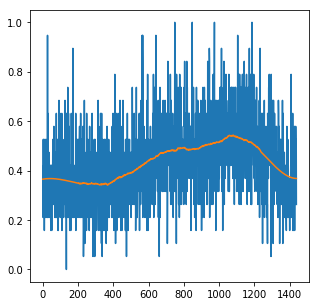

DescribeResult(nobs=1440, minmax=(0, 18), mean=7.732638888888889, variance=8.68246419195429, skewness=0.312149410825412, kurtosis=0.02384381630499144)
DescribeResult(nobs=1440, minmax=(0.0, 1.0), mean=0.42959104938271603, variance=0.026797728987513238, skewness=0.3121494108254127, kurtosis=0.02384381630499144)


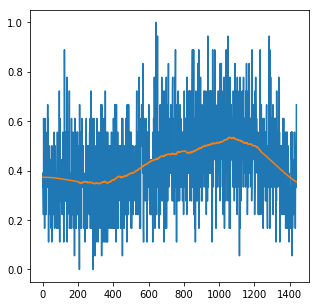

DescribeResult(nobs=1440, minmax=(9, 48), mean=26.446527777777778, variance=33.61075930430082, skewness=0.24015694703345164, kurtosis=0.060816869993862266)
DescribeResult(nobs=1440, minmax=(0.1875, 1.0), mean=0.5509693287037036, variance=0.014588003170269453, skewness=0.24015694703345344, kurtosis=0.060816869993863154)


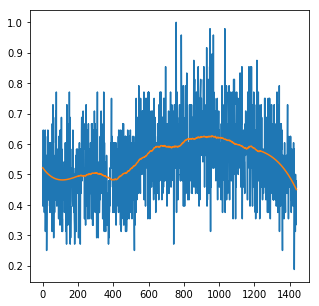

DescribeResult(nobs=1440, minmax=(131, 293), mean=209.28541666666666, variance=731.8107670257124, skewness=-0.06293103829160095, kurtosis=-0.4389935484858176)
DescribeResult(nobs=1440, minmax=(0.447098976109215, 1.0), mean=0.7142846985210467, variance=0.00852439477484551, skewness=-0.06293103829160343, kurtosis=-0.43899354848581673)


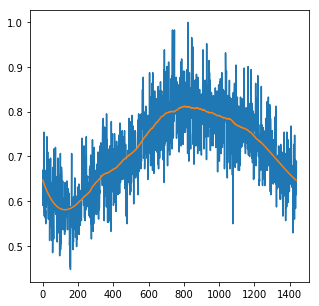

In [23]:
for i, p in enumerate(phases):
    #print("{}, {}".format(p, np.sum(day_min_counter)))
    print(describe(p_counter[i]))
    plt.figure(1, figsize=(5, 5))
    p_norm = p_counter[i]/describe(p_counter[i]).minmax[1]
    print(describe(p_norm))
    yhat = savgol_filter(p_norm, 401, 3)
    plt.plot(p_norm)   
    plt.plot(yhat)   
    plt.show()

In [6]:

x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
                              'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'TIME', 'ARID']
phase_length = {"URZ": {"regP": 200, "regS": 200, "tele": 200, "N": 4000}}
validation_split = 0.1
batch_size = 1024
# load train dataset
pd_train = PhaseFeaturesLoader(filename=dataset_train, validation_split=validation_split,
                         phase_length=phase_length, batch_size=batch_size, x_indices=x_indices)

x_train, y_train = pd_train.get_dataset(expand_dim=False, y_onehot=False)


length regP:5
length regS:5
length tele:5
length N:15


In [7]:
print(x_train[0], y_train[0])

[ 9.48905111e-01  3.99698411e-01  4.20227552e-01  5.93121092e-01
  4.78508215e-01  2.94260097e-01 -4.52674720e-01 -1.78289911e-01
  3.86528500e-01 -1.19353912e-01  3.33333330e-01  8.38896600e-01
  8.13363710e-01  2.00000000e-01  2.15000000e-01  1.20100000e+03
  1.26603022e+08] 3


In [8]:
print(x_train[0,:16], y_train[1])

[ 9.48905111e-01  3.99698411e-01  4.20227552e-01  5.93121092e-01
  4.78508215e-01  2.94260097e-01 -4.52674720e-01 -1.78289911e-01
  3.86528500e-01 -1.19353912e-01  3.33333330e-01  8.38896600e-01
  8.13363710e-01  2.00000000e-01  2.15000000e-01  1.20100000e+03] 3


In [ ]:
enn = EditedNearestNeighbours(ratio="all", n_neighbors=1, random_state=0, return_indices=True)
x_train_resampled, y_train_resampled, indexes = enn.fit_sample(x_train[:, :15], y_train)
print("Shape:", sorted(Counter(y_train_resampled).items()))
print(x_train[1])
print(y_train[1])
print(indexes)
#t = x_train_resampled[1,15]
#hour = time.localtime(t).tm_hour*60
#min = time.localtime(t).tm_min
#print(hour)
#print(describe(x_train[:, 15]))
# day = time.localtime(t).tm_wday*24*60

In [66]:
p_counter = [[], [], [], []]
items = sorted(Counter(y_train_resampled).items())
p_counter = [np.zeros(24*60, dtype="int") for i in phases]
for i, x in enumerate(x_train_resampled):
    t = x_train_resampled[i, 15]
    hour = time.localtime(t).tm_hour*60
    min = time.localtime(t).tm_min
    day_min = hour + min
    p_counter[y_train_resampled[i]][day_min] += 1

print(np.sum(p_counter))




267934


DescribeResult(nobs=1440, minmax=(0, 4), mean=0.10694444444444444, variance=0.15672727974673772, skewness=4.525082965232166, kurtosis=25.01531580985754)
DescribeResult(nobs=1440, minmax=(0.0, 1.0), mean=0.02673611111111111, variance=0.009795454984171108, skewness=4.525082965232166, kurtosis=25.01531580985754)


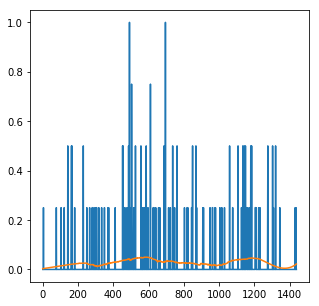

DescribeResult(nobs=1440, minmax=(0, 3), mean=0.0625, variance=0.0753127171646977, skewness=4.955337535977981, kurtosis=28.215682283497568)
DescribeResult(nobs=1440, minmax=(0.0, 1.0), mean=0.020833333333333332, variance=0.008368079684966412, skewness=4.955337535977982, kurtosis=28.215682283497543)


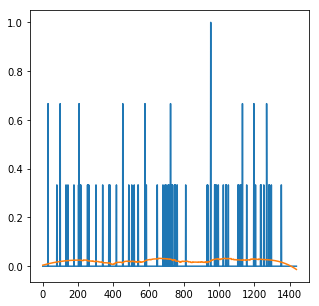

DescribeResult(nobs=1440, minmax=(0, 8), mean=1.6416666666666666, variance=1.8798471160528143, skewness=0.9527002053397017, kurtosis=1.0052162057640261)
DescribeResult(nobs=1440, minmax=(0.0, 1.0), mean=0.20520833333333333, variance=0.029372611188325223, skewness=0.9527002053397017, kurtosis=1.0052162057640261)


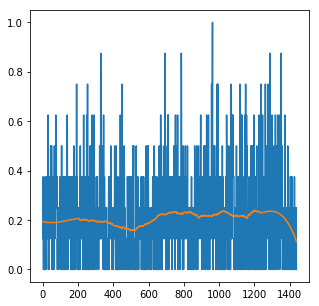

DescribeResult(nobs=1440, minmax=(112, 269), mean=184.25416666666666, variance=592.117425295344, skewness=-0.04152845564274067, kurtosis=-0.32940948736988096)
DescribeResult(nobs=1440, minmax=(0.4163568773234201, 1.0), mean=0.684959727385378, variance=0.00818282535198994, skewness=-0.041528455642743836, kurtosis=-0.3294094873698814)


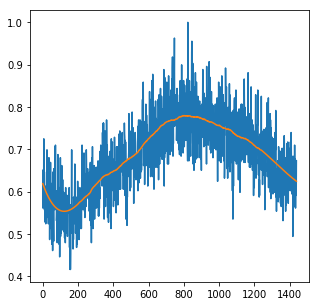

In [67]:
for i, p in enumerate(phases):
    #print("{}, {}".format(p, np.sum(day_min_counter)))
    print(describe(p_counter[i]))
    plt.figure(1, figsize=(5, 5))
    p_norm = p_counter[i]/describe(p_counter[i]).minmax[1]
    print(describe(p_norm))
    yhat = savgol_filter(p_norm, 401, 3)
    plt.plot(p_norm)   
    plt.plot(yhat)   
    plt.show()
    

In [11]:
gcforest = pm.GCForest()
nn = pm.NN(epochs=10)

In [10]:
print(x_train.shape)
#print(x_train)
print(x_train[:,15:])

(30, 17)
[[1.20100000e+03 1.26603022e+08]
 [1.23500000e+03 1.26603525e+08]
 [7.74000000e+02 1.26596087e+08]
 [1.20200000e+03 1.26603024e+08]
 [8.35000000e+02 1.26597200e+08]
 [1.23400000e+03 1.26603523e+08]
 [6.00000000e+00 1.26606921e+08]
 [2.97000000e+02 1.26587561e+08]
 [3.00000000e+00 1.26606917e+08]
 [1.23500000e+03 1.26603526e+08]
 [1.31000000e+03 1.26604665e+08]
 [3.10000000e+02 1.26587892e+08]
 [2.93000000e+02 1.26587299e+08]
 [6.00000000e+00 1.26606919e+08]
 [4.79000000e+02 1.26590423e+08]
 [1.20200000e+03 1.26603023e+08]
 [8.24000000e+02 1.26596810e+08]
 [4.85000000e+02 1.26590424e+08]
 [1.35000000e+02 1.26608918e+08]
 [2.92000000e+02 1.26587298e+08]
 [1.05400000e+03 1.26603497e+08]
 [2.91000000e+02 1.26587296e+08]
 [1.04800000e+03 1.26601124e+08]
 [5.15000000e+02 1.26614127e+08]
 [5.15000000e+02 1.26614126e+08]
 [5.54000000e+02 1.26591874e+08]
 [5.44000000e+02 1.26591873e+08]
 [7.78000000e+02 1.26596095e+08]
 [7.78000000e+02 1.26596094e+08]
 [4.60000000e+02 1.26590129e+08]]


In [53]:
kf = KFold(n_splits=2, shuffle=False)
arids_N = []
fold_counter = 0
for train_index, test_index in kf.split(x_train):
    print("Fold:", fold_counter)
    # print(train_index, test_index)
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train[test_index]
    nn.fit(x_train_fold[:, :16], y_train_fold, verbose=0)
    probability = nn.predict(x_test_fold[:, :16], y_test_fold)
    prob = np.reshape(np.argmax(probability, axis=2), (probability.shape[0], ))
    # print(x_test_fold[:, 16])
    # print(y_test_fold, prob)
    print("confusion matrix:")
    print(confusion_matrix(y_test_fold, prob, labels=[0, 1, 2, 3]))
    arid_list = [int(x_test_fold[i, 16]) for i,x  in enumerate(prob) if x==3]
    arids_N = np.concatenate((arids_N, arid_list))
    #print("arids:", arid_list)

print(arids_N)

Fold: 0
Before resampling: [(0, 2), (1, 4), (2, 3), (3, 6)]
After resampling: [(0, 2), (1, 4), (2, 3), (3, 6)]
Max of acc: 0.38461539149284363, val_acc: 0.5
Min of loss: 9.387831687927246, val_loss: 8.05904769897461
Before resampling: [(0, 3), (1, 1), (2, 2), (3, 9)]
After resampling: [(0, 3), (1, 1), (2, 2), (3, 9)]
Accuracy: 6.666667014360428
confusion matrix:
[[0 3 0 0]
 [0 1 0 0]
 [0 2 0 0]
 [0 9 0 0]]
Fold: 0
Before resampling: [(0, 3), (1, 1), (2, 2), (3, 9)]
After resampling: [(0, 3), (1, 1), (2, 2), (3, 9)]
Max of acc: 0.38461539149284363, val_acc: 0.5
Min of loss: 8.28141975402832, val_loss: 8.311273574829102
Before resampling: [(0, 2), (1, 4), (2, 3), (3, 6)]
After resampling: [(0, 2), (1, 4), (2, 3), (3, 6)]
Accuracy: 13.333334028720856
confusion matrix:
[[2 0 0 0]
 [4 0 0 0]
 [3 0 0 0]
 [6 0 0 0]]
[]


In [54]:
dff = pd.read_csv(filepath_or_buffer=dataset_train, index_col="ARID")
dff.head()
dff.at[arids_N, "CLASS_PHASE"] = "N"
dff.to_csv(dataset_train_out)

In [49]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
print(confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"]))

y_true = [1, 2, 2, 2, 3, 1]
y_pred = [2, 2, 2, 3, 3, 1]
print(confusion_matrix(y_true, y_pred, labels=[1,2,3]))

[[2 0 0]
 [0 0 1]
 [1 0 2]]
[[1 1 0]
 [0 2 1]
 [0 0 1]]


In [25]:
np.reshape(np.argmax(p[0], axis=2),(p[0].shape[0],))

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [31]:
p[0][0]

array([[0., 0., 0., 1.]], dtype=float32)

In [72]:
dff = pd.read_csv(filepath_or_buffer=dataset_train, index_col="ARID")
dff.head()

,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,SLOW,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
ARID,,,,,,,,,,,,,,,,,,,,,
1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,M,0.666667,9.303423,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
3392748,LPAZ,9.660487e+08,Sn,regS,Lg,regP,2.250001,M,0.333333,22.458361,...,3.318087,5.777322,3.312782,0.0,0.000000,0.771338,0.658481,2.513435,3.555231,1.341278
4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,M,0.289855,23.443702,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
5843204,LPAZ,9.915611e+08,Lg,regS,Sn,regP,2.170612,M,0.571429,20.901494,...,2.034370,4.254982,4.254982,0.0,0.000000,1.255465,2.631712,1.016241,2.840468,9.503727
6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,M,0.166667,18.142683,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967


In [92]:
dff.index
arids=[1582602, 4251736, 6033158]
dff.at[1582602, "PHASE"]
dff.loc[arids]
dff.at[arids, "SOURCE"] = "SS"

In [96]:
dff.head()
dff.to_csv(dataset_train_out)

In [49]:
arids=[1582602, 4251736, 6033158]
#dff[dff["ARID"].isin(arids)]["SOURCE"]="A"
dff.at[dff["ARID"].isin(arids), "SOURCE"] = "XX" 

In [51]:
dff[dff["ARID"].isin(arids)]

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,XX,0.666667,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
2,4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,XX,0.289855,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
4,6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,XX,0.166667,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967


In [70]:
#print(dff.index)
#print(dff.index.values)
#print(dff.head())
#dff2=dff.set_index('ARID')
#print(dff2.index)
#print(dff2.index.values)
dff2.head()

,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,SLOW,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
ARID,,,,,,,,,,,,,,,,,,,,,
1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,XX,0.666667,9.303423,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
3392748,LPAZ,9.660487e+08,Sn,regS,Lg,regP,2.250001,M,0.333333,22.458361,...,3.318087,5.777322,3.312782,0.0,0.000000,0.771338,0.658481,2.513435,3.555231,1.341278
4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,XX,0.289855,23.443702,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
5843204,LPAZ,9.915611e+08,Lg,regS,Sn,regP,2.170612,M,0.571429,20.901494,...,2.034370,4.254982,4.254982,0.0,0.000000,1.255465,2.631712,1.016241,2.840468,9.503727
6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,XX,0.166667,18.142683,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967
